In [1]:
import pandas as pd
import numpy as np

In [34]:
def make_target(target):
    if target > 1:
        return 1
    else:
        return target
    
def remove_outliers(value, Q1, Q3):
    IQR = Q3 - Q1
    
    if value < Q1 - 1.5 * IQR:
        result = Q1 - 1.5 * IQR
    elif value > Q3 + 1.5 * IQR:
        result = Q3 + 1.5 * IQR
    else:
        result = value
        
    return result  

def z_norm(value, mean, std):
    
    if std != 0:
        result = (value - mean)/std
    else:
        result = 0
    
    return result

In [14]:
# https://www.kaggle.com/datasets/arjunbhasin2013/ccdata?select=CC+GENERAL.csv
df = pd.read_csv('CC GENERAL.csv', index_col = 0)
df['TARGET'] = df['BALANCE'] / df['CREDIT_LIMIT']
df['TARGET'] = df.apply(lambda x: make_target(x.TARGET), axis = 1)
df.fillna(0, inplace=True)
df.drop('BALANCE', axis=1, inplace=True)
df.head()

,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,TARGET
CUST_ID,,,,,,,,,,,,,,,,,
C10001,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0.040901
C10002,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0.457495
C10003,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0.332687
C10004,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.000000,0.000000,12,0.222223
C10005,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0.681429


In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [16]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [24]:
# Устранение выбросов
X_outliers = X.copy()

for attr_name in X_outliers.columns:    
    # IQR
    Q1 = np.percentile(X_outliers[attr_name], 25, interpolation = 'midpoint')
    Q3 = np.percentile(X_outliers[attr_name], 75, interpolation = 'midpoint')
    X_outliers[attr_name] = X_outliers.apply(lambda x: remove_outliers(x[attr_name],Q1,Q3), axis = 1)

<AxesSubplot:>

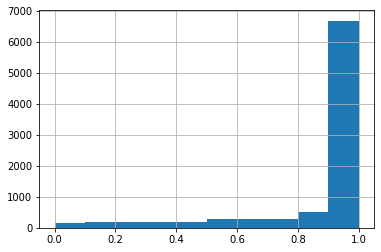

In [33]:
X['BALANCE_FREQUENCY'].hist()

<AxesSubplot:>

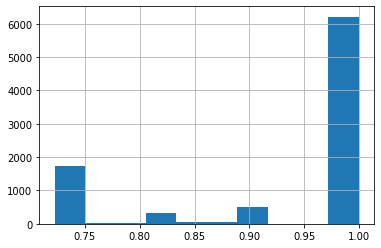

In [28]:
X_outliers['BALANCE_FREQUENCY'].hist()

In [35]:
# Z нормализация
X_norm = X_outliers.copy()

for attr_name in X_norm.columns: 
    mean = np.mean(X_norm[attr_name])
    std = np.std(X_norm[attr_name])
    X_norm[attr_name] = X_norm.apply(lambda x: z_norm(x[attr_name],mean,std), axis = 1)

<AxesSubplot:>

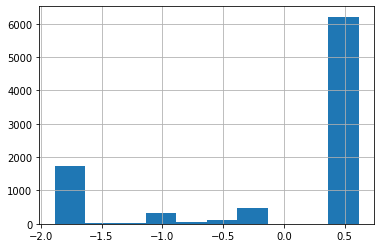

In [36]:
X_norm['BALANCE_FREQUENCY'].hist()

In [47]:
# Корреляция с ЦФ
X_model = X_norm.copy()

df_corr = pd.DataFrame(columns = ['attr_name','corr'])

for i, attr_name in enumerate(X_model.columns): 
    df_corr.loc[i] = [attr_name, abs(X_model[attr_name].corr(y))]

df_corr = df_corr.fillna(0).sort_values('corr', ascending=False)
df_corr

,attr_name,corr
13,MINIMUM_PAYMENTS,0.663925
14,PRC_FULL_PAYMENT,0.517731
0,BALANCE_FREQUENCY,0.470281
8,CASH_ADVANCE_FREQUENCY,0.423627
9,CASH_ADVANCE_TRX,0.410115
4,CASH_ADVANCE,0.332686
5,PURCHASES_FREQUENCY,0.224319
7,PURCHASES_INSTALLMENTS_FREQUENCY,0.182142
3,INSTALLMENTS_PURCHASES,0.138018
11,CREDIT_LIMIT,0.137307


In [110]:
model_attr_list = ['MINIMUM_PAYMENTS']

X_chose = X_model[model_attr_list]
reg = LinearRegression().fit(X_chose, y)
r2 = r2_score(y, reg.predict(X_chose))
new_r2 = r2
print(r2) 

df_r2_main = pd.DataFrame(columns=['attr_name','r2','r2_up'])

for i in range(1,16):  
        
    last_r2 = r2        
    r2 = new_r2

    #print(last_r2, new_r2)

    df_r2 = pd.DataFrame(columns=['attr_name','r2','r2_up'])

    for i_2, attr_name_2 in enumerate(X_model.columns):
        if attr_name_2 not in model_attr_list:

            all_attr_list = model_attr_list.copy()
            all_attr_list.append(attr_name_2)

            X_chose = X_model[all_attr_list]
            reg = LinearRegression().fit(X_chose, y)
            r2 = r2_score(y, reg.predict(X_chose))
            #print(r2, new_r2)
            r2_up = r2/new_r2 - 1

            df_r2.loc[i_2] = [attr_name_2, r2, r2_up]

    df_r2 = df_r2.sort_values('r2_up', ascending=False).head(1)
    model_attr_list.append(df_r2['attr_name'].values[0])
    new_r2 = df_r2['r2'].values[0]

    #display(df_r2) 
    #print(model_attr_list)
    df_r2_main = pd.concat([df_r2_main, df_r2], axis = 0)
    #print('---------------')

df_r2_main['r2_up'] = df_r2_main['r2_up'].round(4)
df_r2_main

0.44079578641655226


,attr_name,r2,r2_up
11,CREDIT_LIMIT,0.579148,0.3139
14,PRC_FULL_PAYMENT,0.638681,0.1028
0,BALANCE_FREQUENCY,0.687261,0.0761
5,PURCHASES_FREQUENCY,0.709751,0.0327
8,CASH_ADVANCE_FREQUENCY,0.718297,0.0120
6,ONEOFF_PURCHASES_FREQUENCY,0.721193,0.0040
10,PURCHASES_TRX,0.721858,0.0009
4,CASH_ADVANCE,0.722451,0.0008
9,CASH_ADVANCE_TRX,0.722661,0.0003
2,ONEOFF_PURCHASES,0.722779,0.0002


In [115]:
df_r2_main.to_excel('sig.xlsx')

In [111]:
significant_list = list(df_r2_main.query('r2_up > 0.01')['attr_name'])
significant_list.append('MINIMUM_PAYMENTS')
significant_list

['CREDIT_LIMIT',
 'PRC_FULL_PAYMENT',
 'BALANCE_FREQUENCY',
 'PURCHASES_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'MINIMUM_PAYMENTS']

In [112]:
X_significant = X_model[significant_list]
X_significant.head()

,CREDIT_LIMIT,PRC_FULL_PAYMENT,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,MINIMUM_PAYMENTS
CUST_ID,,,,,,
C10001,-1.010317,-0.629277,-1.021875,-0.806490,-0.730084,-0.750794
C10002,0.762790,0.973961,-0.202708,-1.221758,0.717792,0.967875
C10003,0.910549,-0.629277,0.616459,1.269843,-0.730084,0.147895
C10004,0.910549,-0.629277,-1.886552,-1.014125,-0.247460,-1.007830
C10005,-0.951214,-0.629277,0.616459,-1.014125,-0.730084,-0.556821


In [113]:
X_significant.corr()

,CREDIT_LIMIT,PRC_FULL_PAYMENT,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY,MINIMUM_PAYMENTS
CREDIT_LIMIT,1.000000,0.030388,0.108237,0.118362,0.128262,0.323335
PRC_FULL_PAYMENT,0.030388,1.000000,-0.183459,0.316356,-0.268737,-0.354950
BALANCE_FREQUENCY,0.108237,-0.183459,1.000000,0.222217,0.186646,0.374087
PURCHASES_FREQUENCY,0.118362,0.316356,0.222217,1.000000,-0.336823,-0.035873
CASH_ADVANCE_FREQUENCY,0.128262,-0.268737,0.186646,-0.336823,1.000000,0.383205
MINIMUM_PAYMENTS,0.323335,-0.354950,0.374087,-0.035873,0.383205,1.000000


In [116]:
X_significant.corr().to_excel('corr.xlsx')

In [114]:
np.linalg.det(X_significant.corr())

0.38483433265853767

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_significant, y, test_size=0.3, random_state=1)

logistic = RandomForestRegressor(random_state=0)
distributions = dict(max_depth=[2,3,4,5], min_samples_split=[2,3,4], min_samples_leaf=[1,2,3])

clf = RandomizedSearchCV(logistic, distributions, random_state=0)

clf.fit(X_train, y_train)

train_r2 = r2_score(y_train, clf.predict(X_train))
test_r2 = r2_score(y_test, clf.predict(X_test))

print(clf.best_params_)
print(train_r2, test_r2)

{'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}
0.8604916438469484 0.8346055739683361


In [95]:
reg = LinearRegression().fit(X_train, y_train)

train_r2 = r2_score(y_train, reg.predict(X_train))
test_r2 = r2_score(y_test, reg.predict(X_test))

print(train_r2, test_r2)

0.7201202986720279 0.7137320978380948
